# Mountain Car DQN

## Imports

In [1]:
import os
import time
from abc import ABC, abstractmethod
from enum import Enum
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

from IPython.display import clear_output

%pip install swig
%pip install "gymnasium[box2d]"

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Class definition

In [2]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    BATCH_SIZE = 32
    EPSILON_START = 1
    EPSILON_CUTOFF = 0.0
    EPSILON_DECAY = 0.987
    GAMMA = 0.9
    LR = 75e-5
    MEMORY_SIZE = 50000

    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.memory = ReplayBuffer(self.MEMORY_SIZE)
        self.epsilon = self.EPSILON_START
        self.total_steps = 0

    def select_e_greedy_action(self, env, state):
        if random.random() < self.epsilon:
            return random.randint(0, env.action_space.n - 1)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                return self.policy_net(state).argmax(dim=1).item()

    def select_greedy_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            return self.policy_net(state).argmax(dim=1).item()

    def decay_epsilon(self):
        self.total_steps += 1
        self.epsilon = max(self.EPSILON_CUTOFF, self.epsilon * self.EPSILON_DECAY)

    def step(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        batch = self.memory.sample(self.BATCH_SIZE)

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device).unsqueeze(1)
        current_q = self.policy_net(states).gather(1, actions)
        next_q = self.target_net(next_states).max(1, keepdim=True)[0].detach()
        target_q = rewards + (self.GAMMA * next_q * (1 - dones))

        loss = F.mse_loss(target_q, current_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


## Training function

In [7]:

def train_q_values(env, env_name, target_update_interval=100, training_episodes=1000, agent_class=DQNAgent):
    OBS_HIGH_VALUES = env.observation_space.high
    CONVERGENCE_TOLERANCE = 0.01
    
    agent = agent_class(env)
    rewards_per_episode = []
    steps_per_episode = []
    epsilon_values = []
    episode_times = []
    start_episode = 0
    early_stop_counter = 0

    for episode in range(start_episode, training_episodes):
        start_time = time.time()
        obs, _ = env.reset()
        state = obs
        total_reward = 0
        episode_over = False
        steps_taken = 0
        episode_transitions = []

        epsilon_values.append(agent.epsilon)

        while not episode_over:
            action = agent.select_e_greedy_action(env, state)
            obs, reward, done, truncated, _ = env.step(action)
            reward += 2 ** (abs(state[1]) * 100)
            reward += 10000000 if state[0] >= np.max(OBS_HIGH_VALUES[0]) else 0
            next_state = np.array(obs, dtype=np.float32)
            agent.memory.push(state, action, reward, next_state, done)
            episode_over = done or truncated
            state = next_state
            total_reward += reward
            steps_taken += 1
            
            agent.step()
            
            if agent.total_steps % target_update_interval == 0:
                agent.update_target_network()

        if steps_taken <= 110 and abs(agent.epsilon - agent.EPSILON_CUTOFF) <= CONVERGENCE_TOLERANCE:
            print("Early stopping condition met! Stopping training.")
            print(f"Episode {episode + 1:}: Total Reward: {total_reward:.3f}, Epsilon: {agent.epsilon:.3f}, Steps: {steps_taken}, Time: {episode_time:.2f}s")
            break
        
        agent.decay_epsilon()
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps_taken)
        end_time = time.time()
        episode_time = end_time - start_time
        episode_times.append(episode_time)

        if episode % 10 == 0:
            print(f"Episode {episode + 1:}: Total Reward: {total_reward:.3f}, Epsilon: {agent.epsilon:.3f}, Steps: {steps_taken}, Time: {episode_time:.2f}s")
        if episode % 100 == 0:
            # Saving model
            checkpoint = {
                'policy_net_state_dict': agent.policy_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'total_steps': agent.total_steps,
                'current_episode': episode,
                'rewards_per_episode': rewards_per_episode,
                'epsilon_values': epsilon_values,
                'episode_times': episode_times,
                'steps_per_episode': steps_per_episode
            }
            torch.save(checkpoint, "dqn_mountain_car_env_v0_checkpoint.pth")
            torch.save(agent.policy_net.state_dict(), "dqn_mountain_car_env_v0.pth")
            print("Checkpoint Reached!")
    
    return agent, rewards_per_episode, epsilon_values, episode_times, steps_per_episode
     


## Mountain Car Training

In [9]:
env_name = "MountainCar-v0"
mountain_env = gym.make(env_name, max_episode_steps=1000, render_mode="rgb_array")

trained_agent, rewards_per_episode, epsilon_values, episode_times, steps_per_episode = train_q_values(mountain_env, env_name, training_episodes=2000)
checkpoint = {
    'policy_net_state_dict': trained_agent.policy_net.state_dict(),
    'optimizer_state_dict': trained_agent.optimizer.state_dict(),
    'total_steps': trained_agent.total_steps,
    'rewards_per_episode': rewards_per_episode,
    'epsilon_values': epsilon_values,
    'episode_times': episode_times,
    'steps_per_episode': steps_per_episode
}
torch.save(checkpoint, "dqn_mountain_car_env_v0_checkpoint.pth")
torch.save(trained_agent.policy_net.state_dict(), "dqn_mountain_car_env_v0.pth")

Episode 1: Total Reward: 638.336, Epsilon: 0.987, Steps: 1000, Time: 1.54s
Checkpoint Reached!
Episode 11: Total Reward: 3664.634, Epsilon: 0.866, Steps: 1000, Time: 1.51s
Episode 21: Total Reward: 616.177, Epsilon: 0.760, Steps: 1000, Time: 1.54s
Episode 31: Total Reward: 1997.453, Epsilon: 0.667, Steps: 1000, Time: 1.62s
Episode 41: Total Reward: 5179.178, Epsilon: 0.585, Steps: 1000, Time: 1.59s
Episode 51: Total Reward: 3577.151, Epsilon: 0.513, Steps: 866, Time: 1.61s
Episode 61: Total Reward: 4241.324, Epsilon: 0.450, Steps: 1000, Time: 1.63s
Episode 71: Total Reward: 2731.526, Epsilon: 0.395, Steps: 775, Time: 1.34s
Episode 81: Total Reward: 8394.433, Epsilon: 0.346, Steps: 1000, Time: 1.59s
Episode 91: Total Reward: 3864.778, Epsilon: 0.304, Steps: 1000, Time: 1.63s
Episode 101: Total Reward: 3036.201, Epsilon: 0.267, Steps: 1000, Time: 1.80s
Checkpoint Reached!
Episode 111: Total Reward: 1884.660, Epsilon: 0.234, Steps: 168, Time: 0.27s
Episode 121: Total Reward: 2702.131, Eps

## Training Results

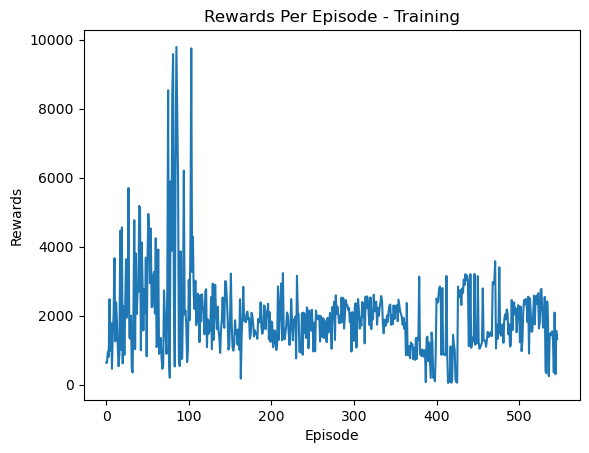

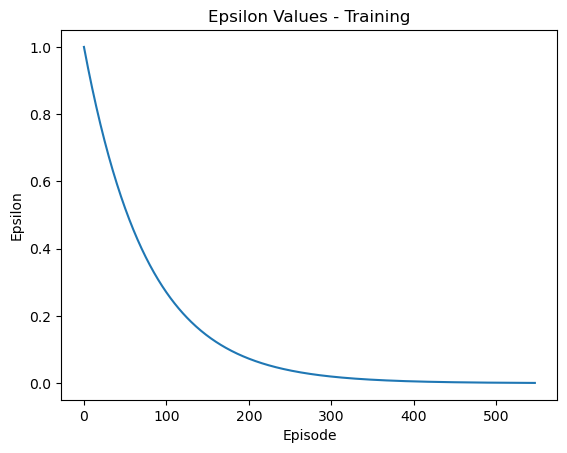

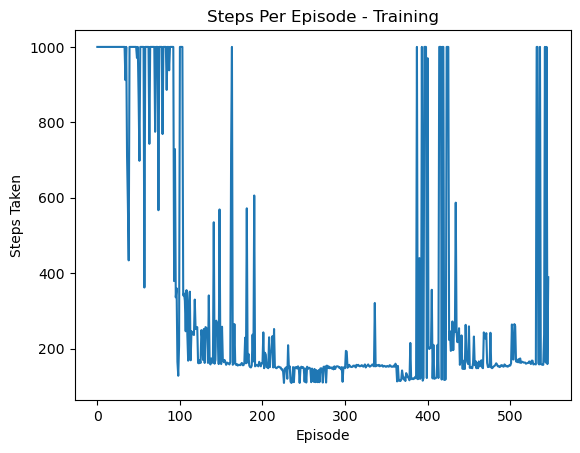

In [7]:
results = torch.load("dqn_mountain_car_env_v0_checkpoint.pth", weights_only=False)

rewards_per_episode = results["rewards_per_episode"]
epsilon_values = results["epsilon_values"]
steps_per_episode = results["steps_per_episode"]

plt.plot(rewards_per_episode)
plt.title("Rewards Per Episode - Training")
plt.xlabel("Episode")
plt.ylabel("Rewards")

plt.show()

plt.plot(epsilon_values)
plt.title("Epsilon Values - Training")
plt.xlabel("Episode")
plt.ylabel("Epsilon")

plt.show()

plt.plot(steps_per_episode)
plt.title("Steps Per Episode - Training")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")

plt.show()


## Mountain Car - Evaluation

Episode 1: Total Reward = -1000.0, Steps taken: 1000
Episode 2: Total Reward = -164.0, Steps taken: 164
Episode 3: Total Reward = -162.0, Steps taken: 162
Episode 4: Total Reward = -163.0, Steps taken: 163
Episode 5: Total Reward = -171.0, Steps taken: 171
Episode 6: Total Reward = -178.0, Steps taken: 178
Episode 7: Total Reward = -159.0, Steps taken: 159
Episode 8: Total Reward = -159.0, Steps taken: 159
Episode 9: Total Reward = -159.0, Steps taken: 159
Episode 10: Total Reward = -158.0, Steps taken: 158

Average reward over 10 episodes: -247.3
Average steps taken over 10 episodes: 247.3



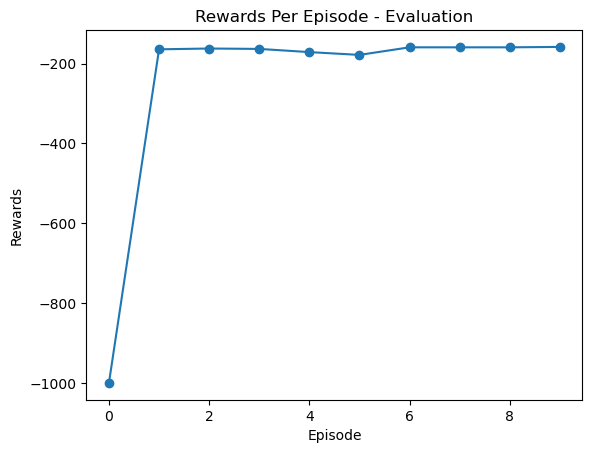

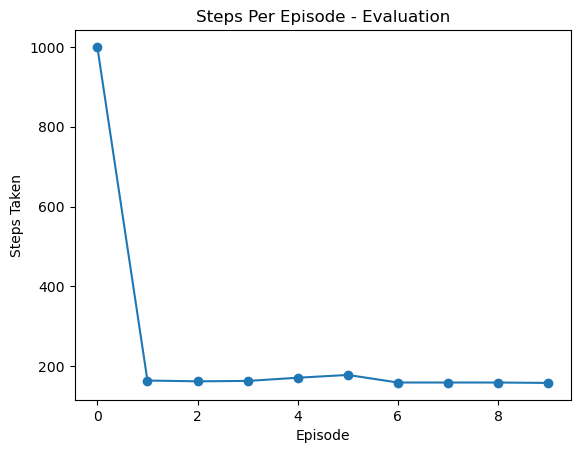

In [25]:
steps_arr = []
rewards_arr = []

env_name = "MountainCar-v0"
mountain_env = gym.make(env_name, max_episode_steps=1000, render_mode="rgb_array")

trained_agent = DQNAgent(mountain_env)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_agent.policy_net.load_state_dict(torch.load("dqn_mountain_car_env_v0.pth", map_location=device, weights_only=True))

for episode in range(10):
    obs, _ = mountain_env.reset()
    state = obs
    tot_reward = 0
    episode_over = False
    steps_taken = 0
    
    while not episode_over:
        with torch.no_grad():
            action = trained_agent.select_greedy_action(state)
        obs, reward, done, truncated, _ = mountain_env.step(action)
        episode_over = done or truncated
        state = np.array(obs, dtype=np.float32)
        steps_taken +=1
        tot_reward += reward
    rewards_arr.append(tot_reward)
    steps_arr.append(steps_taken)
    print(f"Episode {episode + 1}: Total Reward = {tot_reward}, Steps taken: {steps_taken}")

print(f"\nAverage reward over 10 episodes: {np.mean(rewards_arr)}")
print(f"Average steps taken over 10 episodes: {np.mean(steps_arr)}\n")

plt.plot(rewards_arr, marker="o")
plt.title("Rewards Per Episode - Evaluation")
plt.xlabel("Episode")
plt.ylabel("Rewards")

plt.show()

plt.plot(steps_arr, marker="o")
plt.title("Steps Per Episode - Evaluation")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")

plt.show()